<a href="https://colab.research.google.com/github/rafagutzlaff/PredictionVolumeBTCBR/blob/main/Previs%C3%A3o_Volumes_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Os dados utilizados neste script foram obtidos através da API do site CoinTradeMonitor e da biblioteca yFinance.**

Podendo ser baixados novamente, ou serem lidos diretamente na pasta /dados


In [ ]:
# Google Colab requer a instalação abaixo
#!pip install pmdarima
#!pip install yfinance

# importação para uso geral
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
plt.style.use('seaborn') 

# importa biblioteca Yahoo Finance
import yfinance as yf

# importa biblioteca utilizada para fazer solicitações HTTP
import requests
import csv

# importa bibliotecas para serem utilizadas no modelo auto-arima
import pmdarima as pm
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Bibliotecas para utilização das métricas do Sklearn
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Importação para utilização do modelo de LSTM
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking, Embedding

# Bibliotecas para uso do statsmodels
import statsmodels.api as sm
from scipy import stats

# importações para utilizar o Facebook Prophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

# Para utilização na importação de arquivos do Google Drive para o Google Colab
from google.colab import drive
drive.mount('/content/drive')

# bibliotecas para trabalhar offline com a biblioteca
import plotly
import plotly.offline as py
import plotly.graph_objs as go # criará de fato os gráficos
from plotly.offline import plot, iplot
import cufflinks as cf # para conectar o plotly ao pandas
cf.go_offline()
plotly.offline.init_notebook_mode(connected = True)
import plotly.io as pio
# escolhe a opção de renderização no Google Colab
pio.renderers.default = 'colab'

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Realiza a importação dos dados de volumes de bitcoins negociados por exchanges brasileiras através da API CointraderMonitor**

In [ ]:
# cria o arquivo VolumeBTC_Brasil.csv via Jupyter
FileCSV = open('VolumeBTCBrasil.csv', 'w', newline='', encoding='utf-8')

# cria o arquivo VolumeBTC_Brasil.csv via Google Colab
#FileCSV = open('/content/drive/My Drive/datasets/VolumeBTCBrasil.csv', 'w', newline='', encoding='utf-8')

# cria objeto de gravação
w = csv.writer(FileCSV)
w.writerow(["Date", "Volume BTC"])

# informação do período a ser pesquisado
data_inicial = datetime.strptime('2018-06-01', '%Y-%m-%d')
data_final = datetime.strptime('2021-05-31', '%Y-%m-%d')

# iteração diária para todo o período informado
while (data_inicial <= data_final):
    
    #utiliza a API do cointrademonitor para recuperar as informações diariamente
    response = requests.get('https://cointradermonitor.com/api/pbb/v1/ticker?exchanges=true&time='+
                            data_inicial.strftime('%Y-%m-%d')+'T00:00:00-0300')
    data = response.json()
    
     # escreve os dados no arquivo csv (data e volume)
    w.writerow([data_inicial, data["volume24h"]])
    
     #incrementa em um dia o período a ser pesquisado
    data_inicial = data_inicial + timedelta(days=1)
FileCSV.close()


In [ ]:
# para importação via google Drive
#df = pd.read_csv('/content/drive/My Drive/datasets/VolumeBTCBrasil.csv')
#df.head()

# para importação via Jupyter Notebook
df = pd.read_csv('VolumeBTCBrasil.csv')
df.head()

,Date,Volume BTC
0,2018-06-01 00:00:00,217.29
1,2018-06-02 00:00:00,237.19
2,2018-06-03 00:00:00,139.18
3,2018-06-04 00:00:00,145.76
4,2018-06-05 00:00:00,298.21


In [ ]:
# mostra a quantidade de linhas do dataset
df.count()

Date          1096
Volume BTC    1096
dtype: int64

**Realiza o download do dataset relativo aos valores do** **bitcoin**


In [ ]:
# realiza o download de dados históricos do Bitcoin conforme período informado
df_valores = yf.download("BTC-USD", start="2018-06-01", end="2021-05-31")

# cria o arquivo ValoresBTC_USD via Google Colab
#df_valores.to_csv('/content/drive/My Drive/datasets/ValoresBTC_USD.csv')

# Para o Jupyter notebook
df_valores.to_csv('ValoresBTC_USD.csv')

# mostra a quantidade de linhas do dataset
df_valores.count()

[*********************100%***********************]  1 of 1 completed


Open         1092
High         1092
Low          1092
Close        1092
Adj Close    1092
Volume       1092
dtype: int64

In [ ]:
# mostra os primeiros valores
df_valores.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-01,7500.700195,7604.729980,7407.339844,7541.450195,7541.450195,4921460224
2018-06-02,7536.720215,7695.830078,7497.259766,7643.450195,7643.450195,4939299840
2018-06-03,7632.089844,7754.890137,7613.040039,7720.250000,7720.250000,4851760128
2018-06-04,7722.529785,7753.819824,7474.040039,7514.470215,7514.470215,4993169920
2018-06-05,7500.899902,7643.229980,7397.000000,7633.759766,7633.759766,4961739776


**Realiza a junção dos dois arquivos obtidos anteriormente para "arquivo_geral.csv"**

In [ ]:
# realiza a leitura dos arquivos CSV

# para usar no Jupyter
df_VolumeBTCBrasil = pd.read_csv('VolumeBTCBrasil.csv',sep=',')

# para usar no Google Colab
#df_VolumeBTCBrasil = pd.read_csv('/content/drive/My Drive/datasets/VolumeBTCBrasil.csv')

# para usar no Jupyter
df_BTC_USD = pd.read_csv('ValoresBTC_USD.csv',sep=',')

# para usar no Google Colab
#df_BTC_USD = pd.read_csv('/content/drive/My Drive/datasets/ValoresBTC_USD.csv')

# converte os campos Date dos arquivos para formato data
df_VolumeBTCBrasil['Date'] = pd.to_datetime(df_VolumeBTCBrasil['Date'])
df_BTC_USD['Date'] = pd.to_datetime(df_BTC_USD['Date'])

# faz a junção dois dataframe através do campo data
df_geral = pd.merge(df_VolumeBTCBrasil, df_BTC_USD, on='Date', how='outer')


In [ ]:
# verifica quais e quantos campos possuem valores nulos
df_geral.isnull().sum()

Date          0
Volume BTC    0
Open          4
High          4
Low           4
Close         4
Adj Close     4
Volume        4
dtype: int64

In [ ]:
# exclui as linhas que possuem valores vazios
df_geral.dropna(inplace=True)

df_geral.isnull().sum()

Date          0
Volume BTC    0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
dtype: int64

In [ ]:
# escreve o novo dataset no arquivo CSV via Google Colab
#df_geral.to_csv('/content/drive/My Drive/datasets/arquivo_geral.csv', index=False)

# para usar no Jupyter
df_geral.to_csv("arquivo_geral.csv")

In [ ]:
# localiza o maior da coluna Close no dataset
df_geral.loc[df_geral['Close'].idxmax()]

Date          2021-04-13 00:00:00
Volume BTC                 840.65
Open                        59890
High                      63742.3
Low                         59870
Close                     63503.5
Adj Close                 63503.5
Volume                6.99835e+10
Name: 1047, dtype: object

In [ ]:
# mostra as principais estatísticas descritivas
df_geral.describe()

,Volume BTC,Open,High,Low,Close,Adj Close,Volume
count,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1.092000e+03
mean,850.054304,13958.166651,14337.051936,13545.027368,13983.375037,13983.375037,2.617242e+10
std,621.365364,14495.795984,14971.848940,13927.311506,14508.514500,14508.514500,2.283966e+10
min,48.160000,3236.274658,3275.377930,3191.303467,3236.761719,3236.761719,2.923670e+09
25%,421.645000,6520.555054,6622.052612,6447.870117,6526.794922,6526.794922,9.003664e+09
50%,746.540000,8807.428223,8957.514160,8665.192871,8806.394531,8806.394531,2.076196e+10
75%,1106.460000,11382.028564,11594.471680,11169.713135,11386.230957,11386.230957,3.616280e+10
max,6237.620000,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


In [ ]:
# gráfico dos valores de fechamento do bitcoin, usando o ploty
data = [go.Scatter(x=df_geral.Date, y=df_geral['Close'])]

py.iplot(data)

In [ ]:
# plota o gráfico CandleStick referente as cotações do BTC
trace = go.Candlestick(x=df['Date'],
open=df_geral['Open'],
high=df_geral['High'],
low=df_geral['Low'],
close=df_geral['Close'])
data = [trace]
py.iplot(data, filename='simple_candlestick')

In [ ]:
# plota o gráfico das variações diárias (valores obtidos da subtração da coluna Close e da coluna Open )
trace = go.Scatter(x = df_geral['Date'], y = df_geral['Close']-df_geral['Open'], mode = 'lines+markers')
data = [trace]
py.iplot(data)

In [ ]:
# localiza a linha onde ocorre o maior valor na diferença Close - Open
df_geral.loc[(df_geral['Close']-df_geral['Open']).idxmax()]

Date          2021-02-08 00:00:00
Volume BTC                 768.77
Open                      38886.8
High                      46203.9
Low                       38076.3
Close                     46196.5
Adj Close                 46196.5
Volume                1.01467e+11
Name: 983, dtype: object

In [ ]:
# plota o gráfico relativo ao volume de bitcoin negociado por corretoras brasileiras
data = [go.Scatter(x=df_geral['Date'],y=df_geral['Volume BTC'])]
py.iplot(data)

In [ ]:
# mostra o dia com maior volume de BTC negociado 
df_geral.loc[df_geral['Volume BTC'].idxmax()]

Date          2021-05-20 00:00:00
Volume BTC                6237.62
Open                      36753.7
High                        42463
Low                       35050.6
Close                     40782.7
Adj Close                 40782.7
Volume                8.82819e+10
Name: 1084, dtype: object

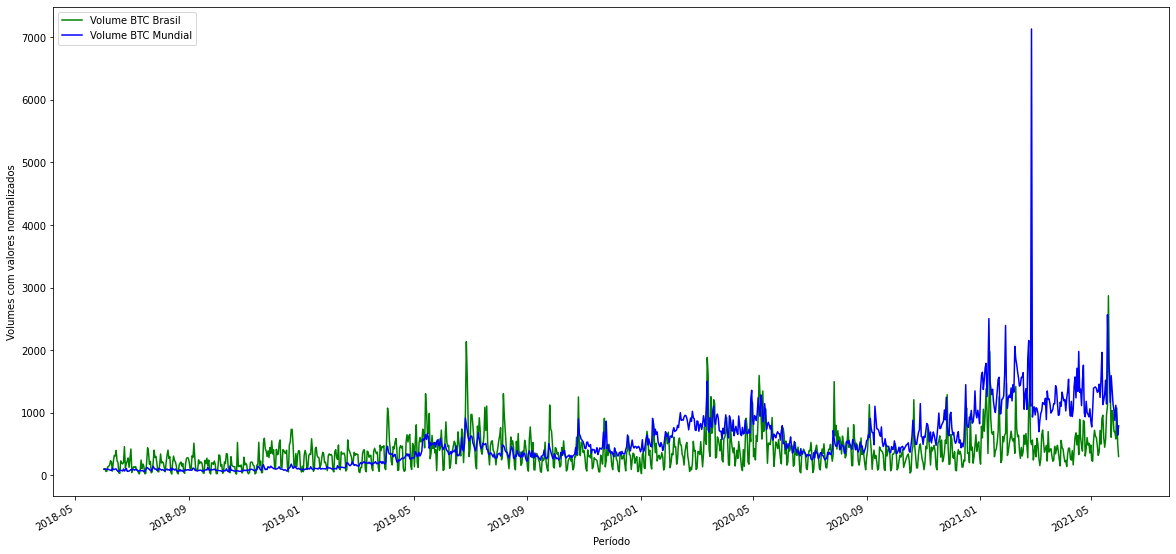

In [ ]:
# análise conjunta dos valores negociados por exchanges brasileiras e o volume mundial
df_geral.reset_index(inplace=True)
df_geral.set_index('Date', inplace=True)

# normaliza os dados ref. aos volumes
(df_geral['Volume BTC']/df_geral['Volume BTC'].iloc[0]*100).plot(figsize=(20,10), color='green', label='Volume BTC Brasil')
(df_geral['Volume']/df_geral['Volume'].iloc[0]*100).plot(figsize=(20,10), color='blue', label='Volume BTC Mundial')

# plota o gráfico de volumes normalizados
plt.ylabel('Volumes com valores normalizados')
plt.xlabel('Período')
plt.legend()
plt.show()

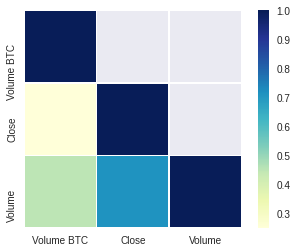

In [ ]:
# Fazer mapa de correlação

#Função para criação do mapa de correlação das séries
def plot_corr(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask, 1)] = True
    sns.heatmap(corr, mask=mask, cmap='YlGnBu', square=True, linewidths=.5)
    
# Cálculo da correlação
corr = df_geral[['Volume BTC', 'Close', 'Volume']]
plot_corr(corr.corr())

# Criação dos modelos preditivos

# ***1 - Auto Arima***


In [ ]:
# cria dois datasets: treino e teste
train = df_geral.loc['2018-06-01':'2020-12-31']
test = df_geral.loc['2021-01-01':'2021-05-31']


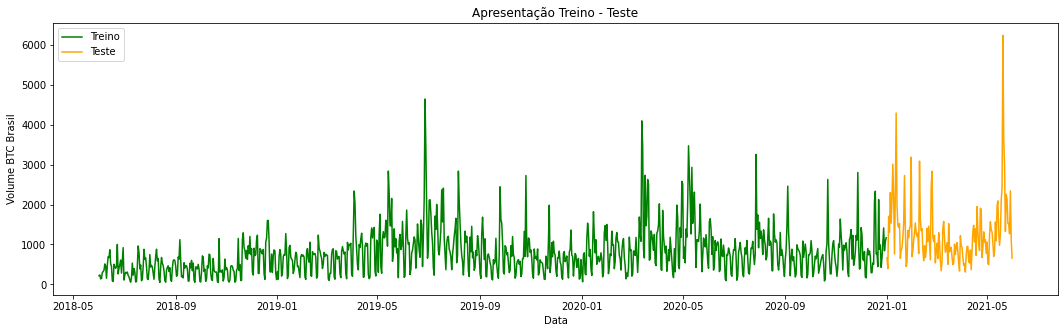

In [ ]:
# plota o gráfico conjunto de treino e teste
plt.figure(figsize=(18,5))
plt.title('Apresentação Treino - Teste')
plt.plot(train['Volume BTC'], color='green')
plt.plot(test['Volume BTC'], color='orange')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('Volume BTC Brasil')
plt.show()

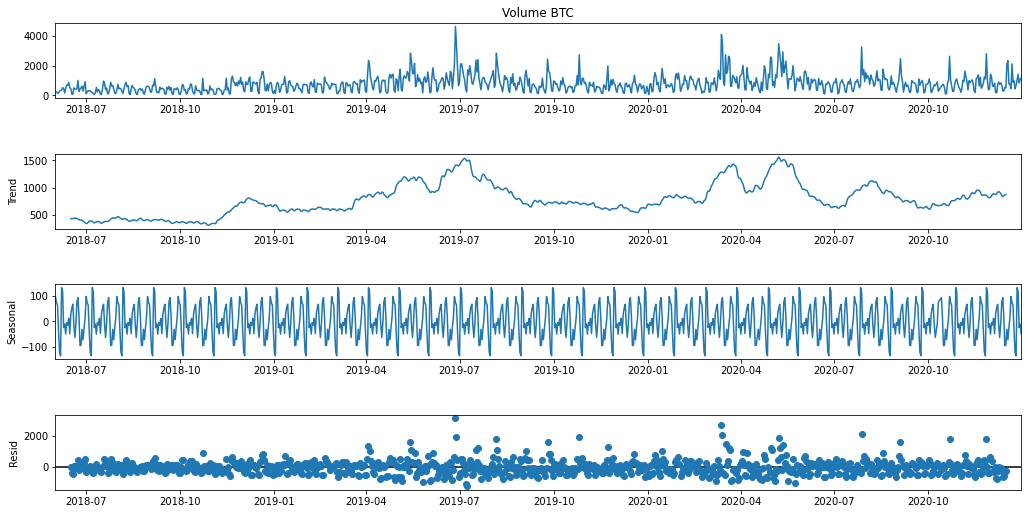

In [ ]:
#gráfico com frequencia de 30 dias
season = sm.tsa.seasonal_decompose(train['Volume BTC'], freq=30)
fig = season.plot();
fig.set_size_inches(16,8)

In [ ]:
# Realiza o Teste de Dickey Fuller
adfinput = adfuller(train['Volume BTC'])
adftest = pd.Series(adfinput[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                          'Lags Usados','Número de observações usadas'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Valores Críticos (%s)"%key] = value.round(4) 
adftest

Teste Estatistico Dickey Fuller     -3.4044
Valor-P                              0.0108
Lags Usados                         21.0000
Número de observações usadas       919.0000
Valores Críticos (1%)               -3.4375
Valores Críticos (5%)               -2.8647
Valores Críticos (10%)              -2.5684
dtype: float64

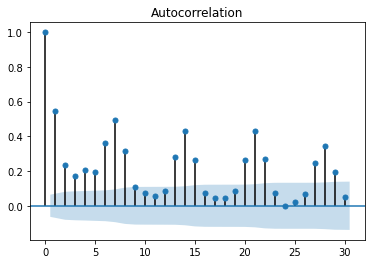

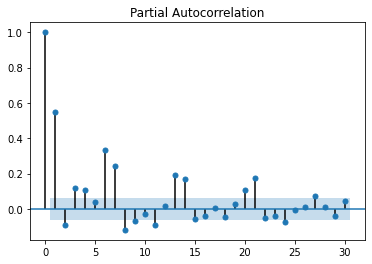

In [ ]:
# plota o gráfico ACF - autocorrelação
plot_acf(train['Volume BTC']);

# plota o gráfico PACF - autocorrelação
plot_pacf(train['Volume BTC']);

In [ ]:
# implementação do modelo auto_arima
# utilizando os valores max_p = 5 e max_q = 5 houve um melhor desempenho
model = pm.auto_arima(train['Volume BTC'], start_p=1, start_q=1,
test='adf', 
max_p=5, max_q=5,
m=1, 
stationary = True, 
seasonal= True, 
start_P=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=14243.898, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=14584.486, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14251.270, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=14289.597, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15599.393, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=14249.676, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=14235.641, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=14246.370, Time=0.47 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=14237.504, Time=0.45 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=14185.595, Time=1.71 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=14247.013, Time=0.64 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=14206.968, Time=1.84 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=14165.242, Time=1.96 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=14228.613, Time=0.81 sec
 ARIMA(2,0,4)(0,0,0

In [ ]:
# treino o modelo de acordo com os parâmetros passados em auto_arima
model.fit(train['Volume BTC'])


ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 4), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  941
Model:               SARIMAX(1, 0, 4)   Log Likelihood               -7075.621
Date:                Fri, 30 Jul 2021   AIC                          14165.242
Time:                        11:57:20   BIC                          14199.171
Sample:                             0   HQIC                         14178.175
                                - 941                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     42.0781     16.794      2.506      0.012       9.163      74.993
ar.L1          0.9459      0.020     48.478      0.000       0.908       0.984
ma.L1         -0.3956      0.031    -12.563      0.0

In [ ]:
#Faz a predição para 12 meses
forecast_arima = model.predict(n_periods=len(test['Volume BTC']))
forecast_arima = pd.DataFrame(forecast_arima, index = test.index,
                              columns=['Prediction'])
conf_int = model.predict(len(test['Volume BTC']), return_conf_int=True, alpha = 0.05) 

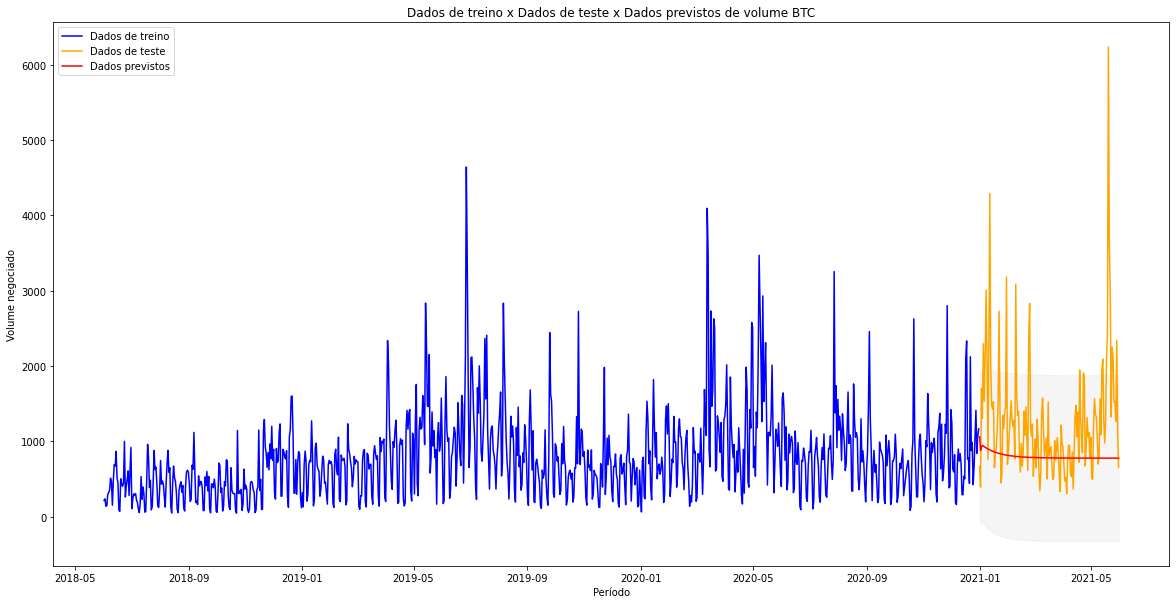

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(20,10))
plt.title('Dados de treino x Dados de teste x Dados previstos de volume BTC')
plt.plot(train['Volume BTC'], color='blue', label ='Dados de treino')
plt.plot(test['Volume BTC'], color = 'orange', label = 'Dados de teste')
plt.fill_between(test.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='grey', alpha=.08)
plt.plot(forecast_arima['Prediction'], color ='red', label ='Dados previstos')
plt.xlabel('Período')
plt.ylabel('Volume negociado')
plt.legend()
plt.show()

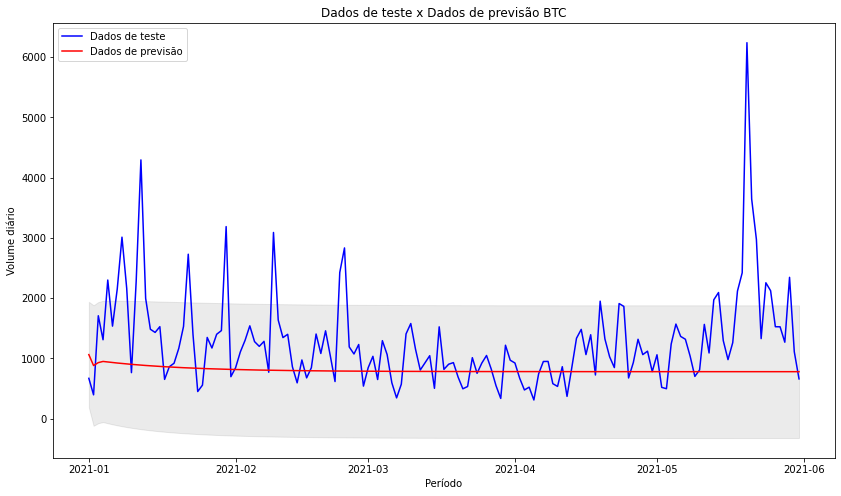

In [ ]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados de previsão BTC')
plt.plot(test['Volume BTC'], color = 'blue', label = 'Dados de teste')
plt.fill_between(test.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados de previsão')
plt.xlabel('Período')
plt.ylabel('Volume diário')
plt.legend()
plt.show()

In [ ]:
#Função para cálculo do mape-erro médio absoluto percentual
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#Cálculo do erro
mse = mean_squared_error(test['Volume BTC'], forecast_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test['Volume BTC'], forecast_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test['Volume BTC'], forecast_arima['Prediction']))
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(test['Volume BTC'], forecast_arima['Prediction'])
print('MAPE: '+str(mape))

MSE: 837409.5101137339
MAE: 584.3214732327905
RMSE: 915.1008196443352
MAPE: 39.92289244198551


# **2 - *Modelo* *Facebook* Prophet**


In [ ]:
# criando um data frame padrão
df_prophet = df[['Date', 'Volume BTC']]

df_prophet['Date'] = df_prophet['Date'].astype('datetime64[ms]')
df_prophet.set_index('Date',inplace=True)

# convertendo em formato data
df_train = df_prophet.loc['2018-06-01':'2020-12-31']
df_test = df_prophet.loc['2021-01-01':'2021-05-31']

df_train


,Volume BTC
Date,
2018-06-01,217.29
2018-06-02,237.19
2018-06-03,139.18
2018-06-04,145.76
2018-06-05,298.21
...,...
2020-12-27,1033.75
2020-12-28,1412.59
2020-12-29,840.99


In [ ]:
# renomeia as colunas do df de treino conforme exigido pelo Prophet
df_train = pd.DataFrame({"ds": df_train.index, "y": df_train['Volume BTC']})
df_train.reset_index(drop = True, inplace = True)
df_train.head()

,ds,y
0,2018-06-01,217.29
1,2018-06-02,237.19
2,2018-06-03,139.18
3,2018-06-04,145.76
4,2018-06-05,298.21


In [ ]:
# renomeia as colunas do df de teste conforme exigido pelo Prophet
df_test = pd.DataFrame({"ds_test": df_test.index, "y_test": df_test['Volume BTC']})
df_test.reset_index(drop = True, inplace = True)
df_test.head()

,ds_test,y_test
0,2021-01-01,667.37
1,2021-01-02,393.54
2,2021-01-03,1705.85
3,2021-01-04,1307.57
4,2021-01-05,2298.75


In [ ]:
# informa o ajuste da tendência
prior_scale = 0.05

# instancia o modelo e define os parâmetros
m = Prophet(changepoint_prior_scale=prior_scale, interval_width=0.95, daily_seasonality=True)
# realiza o treinamento
m.fit(df_train)

In [ ]:
# realiza a predição para um período de 151 dias com frequencia diária
# Período de 151 dias foi escolhido por ser o período de teste disponível para o ano 2021
future = m.make_future_dataframe(periods=151, freq='D')
future = m.predict(future)
future[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1091,2021-05-27,1269.714894,446.998682,2106.845604
1092,2021-05-28,1240.831171,402.573320,2005.719711
1093,2021-05-29,1071.099349,326.356940,1871.540430
1094,2021-05-30,513.787624,-243.641384,1341.245866
1095,2021-05-31,465.570516,-296.661271,1240.226208


Text(50.625, 0.5, 'Volume diário')

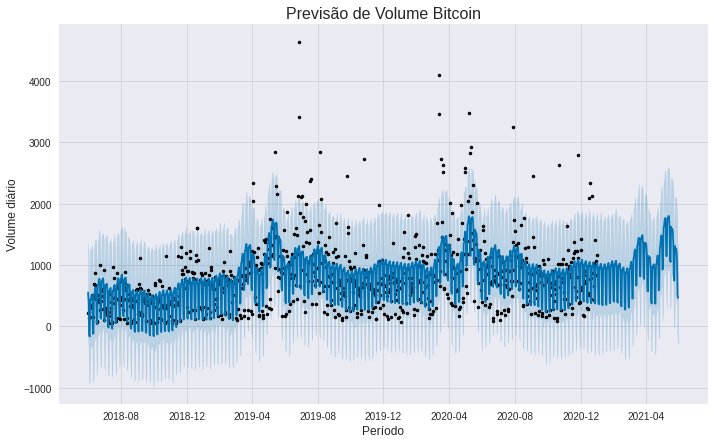

In [ ]:
# Plotagem do gráfico de previsão
fig = m.plot(future)
ax1 = fig.gca()
ax1.set_title("Previsão de Volume Bitcoin", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Volume diário", fontsize=12)



In [ ]:
#Seleciona os dados previstos apenas para o período de teste

final_train = "2020-12-31"

future = future[future['ds'] > final_train]
future.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1091,2021-05-27,808.637451,446.998682,2106.845604,782.124160,836.347442,461.077443,461.077443,461.077443,101.479232,101.479232,101.479232,216.702383,216.702383,216.702383,142.895828,142.895828,142.895828,0.0,0.0,0.0,1269.714894
1092,2021-05-28,808.631781,402.573320,2005.719711,781.928697,836.623923,432.199390,432.199390,432.199390,101.479232,101.479232,101.479232,228.919868,228.919868,228.919868,101.800290,101.800290,101.800290,0.0,0.0,0.0,1240.831171
1093,2021-05-29,808.626111,326.356940,1871.540430,781.647988,836.900405,262.473237,262.473237,262.473237,101.479232,101.479232,101.479232,97.042733,97.042733,97.042733,63.951272,63.951272,63.951272,0.0,0.0,0.0,1071.099349
1094,2021-05-30,808.620441,-243.641384,1341.245866,781.510588,837.176886,-294.832817,-294.832817,-294.832817,101.479232,101.479232,101.479232,-426.166052,-426.166052,-426.166052,29.854002,29.854002,29.854002,0.0,0.0,0.0,513.787624
1095,2021-05-31,808.614771,-296.661271,1240.226208,781.287033,837.453368,-343.044255,-343.044255,-343.044255,101.479232,101.479232,101.479232,-444.452888,-444.452888,-444.452888,-0.070600,-0.070600,-0.070600,0.0,0.0,0.0,465.570516


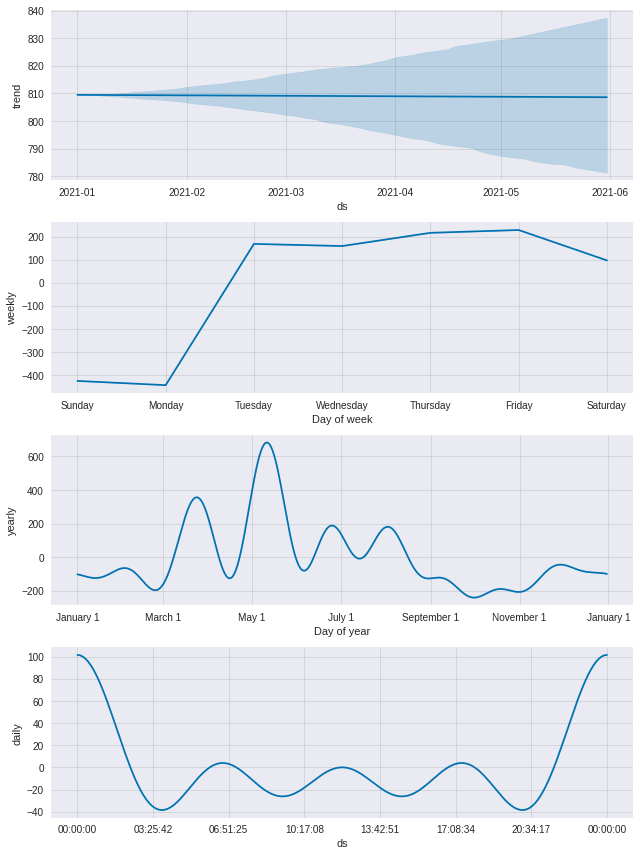

In [ ]:
#Plotagem dos componententes da previsão
fig = m.plot_components(future)

In [ ]:
#Escolhe as datas ('ds' e 'ds_test') como índices
future.set_index(future['ds'], inplace=True) 
df_test.set_index(df_test['ds_test'], inplace=True) 
df_train.set_index(df_train['ds'], inplace=True)

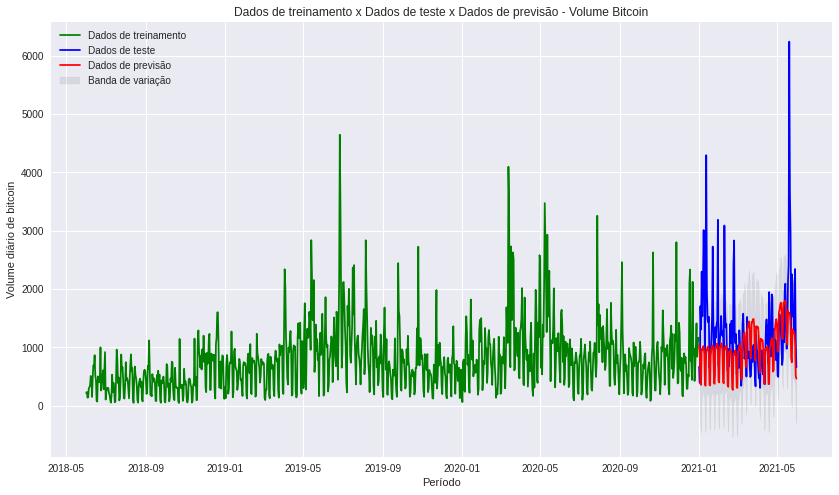

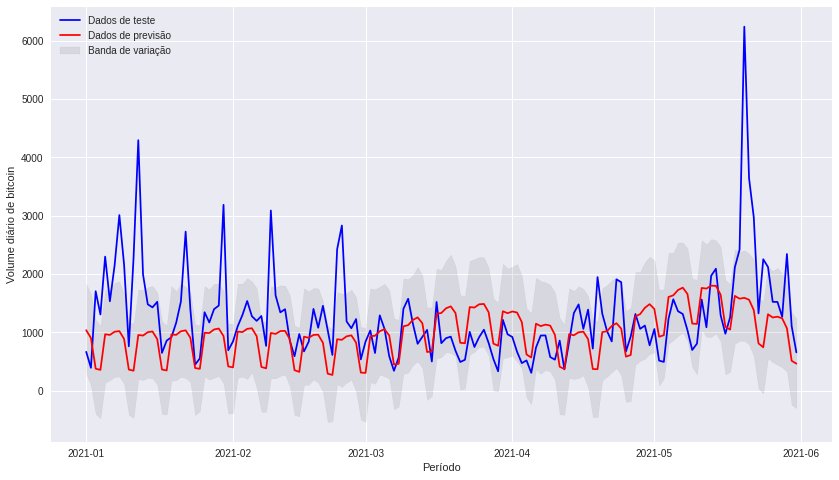

In [ ]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = df_train.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados de previsão - Volume Bitcoin')
plt.plot(df_train['y'], 'green', label='Dados de treinamento')
plt.plot(df_test['y_test'], color = 'blue', label='Dados de teste')
plt.plot(future['yhat'][-n:], color = 'red', label = 'Dados de previsão')
plt.fill_between(future.index[-n:], future['yhat_lower'][-n:], future['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Volume diário de bitcoin")
plt.legend()

#Plotagem do comparativo entre o volume previsto e o volume de validação
plt.figure(figsize=(14,8))
plt.plot(df_test['y_test'], color = 'blue', label='Dados de teste')
plt.plot(future['yhat'], color = 'red', label = 'Dados de previsão')
plt.fill_between(future.index[-n:], future['yhat_lower'][-n:], future['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Volume diário de bitcoin")
plt.legend()
plt.show()

In [ ]:
# define a lista para o cálculo dos erros, restrito ao período previsto
future_erro = future['2021-01-01':'31-05-2021']

In [ ]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(df_test['y_test'], future_erro['yhat']))
print('MSE: ', mean_squared_error(df_test['y_test'], future_erro['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(df_test['y_test'], future_erro['yhat'])))
print('MAPE:', mean_absolute_percentage_error(df_test['y_test'], future_erro['yhat']))


MAE:  551.6285295095711
MSE:  679189.9304026543
RMSE:  824.1298019139062
MAPE: 42.30538282340785


## ***Predição de volume de bitcoins negociados através de LSTM***

## ***Iniciando o treinamento do modelo***

In [ ]:
# atribui o dataset geral para o dataframe de uso no LSTM
df_lstm = df_geral

# Mantem apenas a coluna Volume BTC que será usada no modelo preditivo
df_lstm = df_lstm.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

# cria dois datasets para treino e teste
lstm_treino = df_lstm.loc['2018-06-01':'2020-12-31']
lstm_teste = df_lstm.loc['2021-01-01':'2021-05-31']


In [ ]:
# atribui a coluna "Volume BTC" para o array
lstm_treino_array = lstm_treino.iloc[:,0:1].values

In [ ]:
# normaliza os dados utilizando a função MinMaxScaler()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
lstm_treino_norm = scaler.fit_transform(lstm_treino_array) 
lstm_treino_norm

In [ ]:
#Cria duas listas X_train_lstm, y_train_lstm com 60 timesteps 
timesteps = 60
x_train_lstm = []
y_train_lstm = []
for i in range(timesteps, lstm_treino.shape[0]):
    # Adiciona o timesteps anterior
    x_train_lstm.append(lstm_treino_norm[i-timesteps:i, 0])
    # y_train_lstm será o último volume de fechamento do bitcoin
    y_train_lstm.append(lstm_treino_norm[i, 0]) 
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [ ]:
# Remodela o dataset de treinamento através da função reshape do numpy
# É passado o array x_train_lstm e a nova estrutura sendo um tupla com as seguintes informações 
# x_train_lstm.shape[0] = batch_size, que é o número de informações de volume do período de treinamento
# x_train_lstm.shape[1] = time_step, que é o número de volumes anteriores
# input_dim = 1, que indica que será usado o Volume de bitcoin negociado
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))

In [ ]:
#Criação do modelo LSTM utilizando a biblioteca Keras

# Inicialização do modelo
model_rnn = Sequential()

#O parâmetro return_sequences=True indica que a rede terá mais camadas a frente
#O parâmetro Dropout ajuda no ajuste do Overfitting

# Adiciona a primeira camada LSTM com o Dropout 
model_rnn.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train_lstm.shape[1], 1)))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com o Dropout
model_rnn.add(LSTM(units = 64))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída 
model_rnn.add(Dense(1, activation='linear'))

# Compila a RNN, neste caso utilizando o otimizador 'Adam'
model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

# Faz o treinamento da RNN utilizando o dataset de treinamento
model_rnn.fit(x_train_lstm, y_train_lstm, epochs = 100, batch_size = 32) 

#Mostra o resumo do modelo
model_rnn.summary()

Epoch 1/100
28/28 [==============================] - 7s 92ms/step - loss: 0.0586 - mean_absolute_error: 0.1723
Epoch 2/100
28/28 [==============================] - 3s 91ms/step - loss: 0.0057 - mean_absolute_error: 0.0559
Epoch 3/100
28/28 [==============================] - 3s 91ms/step - loss: 0.0052 - mean_absolute_error: 0.0509
Epoch 4/100
28/28 [==============================] - 3s 91ms/step - loss: 0.0041 - mean_absolute_error: 0.0459
Epoch 5/100
28/28 [==============================] - 3s 91ms/step - loss: 0.0033 - mean_absolute_error: 0.0417
Epoch 6/100
28/28 [==============================] - 3s 92ms/step - loss: 0.0036 - mean_absolute_error: 0.0425
Epoch 7/100
28/28 [==============================] - 3s 91ms/step - loss: 0.0035 - mean_absolute_error: 0.0420
Epoch 8/100
28/28 [==============================] - 3s 91ms/step - loss: 0.0032 - mean_absolute_error: 0.0404
Epoch 9/100
28/28 [==============================] - 3s 91ms/step - loss: 0.0032 - mean_absolute_error: 0.0399
E

In [ ]:
#Carregamentos dos dados de teste para fazer as predições
# atribui a coluna Volume BTC a lista
lstm_teste_array = lstm_teste.iloc[:,0:1].values 


In [ ]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento anteriores não estão no conjunto de teste
combine = pd.concat((lstm_treino['Volume BTC'], lstm_teste['Volume BTC']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(lstm_teste) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [ ]:
# Predição utilizando os dados de teste
x_test_lstm = []
for i in range(timesteps, lstm_teste.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)


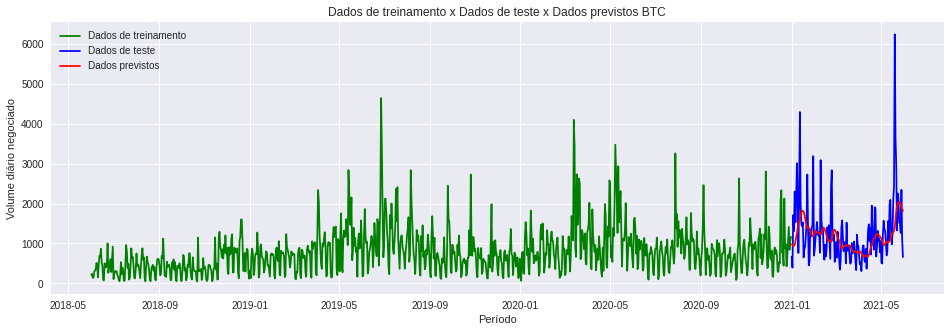

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,5))
plt.plot(lstm_treino.index, lstm_treino['Volume BTC'], color='green', label = 'Dados de treinamento')
plt.plot(lstm_teste.index, lstm_teste['Volume BTC'], color = 'blue', label = 'Dados de teste')
plt.plot(lstm_teste.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos BTC')
plt.xlabel('Período')
plt.ylabel('Volume diário negociado')
plt.legend()
plt.grid(True)
plt.show()

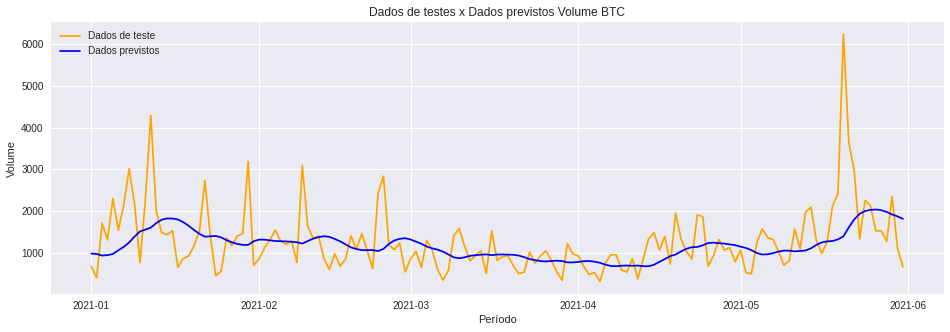

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,5))
plt.plot(lstm_teste.index, lstm_teste['Volume BTC'], color = 'orange', label = 'Dados de teste')
plt.plot(lstm_teste.index, predictions_lstm, color = 'blue', label = 'Dados previstos')
plt.title('Dados de testes x Dados previstos Volume BTC')
plt.xlabel('Período')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(lstm_teste['Volume BTC'],predictions_lstm))
print('MSE: ', mean_squared_error(lstm_teste['Volume BTC'],predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(lstm_teste['Volume BTC'],predictions_lstm)))
print('MAPE:', mean_absolute_percentage_error(lstm_teste['Volume BTC'], predictions_lstm))


MAE:  492.9915702930981
MSE:  571187.4580769852
RMSE:  755.769447700147
MAPE: 53.721968558029
